In [116]:
# Import necessary library
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from glove import Corpus, Glove
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [98]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jwong/nltk_data...


True

In [156]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jwong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Observation of the Dataset

In [188]:
# Loading the dataset
reviews = pd.read_csv("./data/train.csv")
reviews.head(6)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,JYgoAQHdJWKPArQDvBEBng,0,2016-03-30 21:40:34,0,JlUcJiIy24pw5jStCLtavg,5,Best Sunday buffet in the two cities of Charlo...,1,SxLNrLxHm0aEw-kLrbPLew
1,AASa5G_OHCxGQ0tbjT_2tw,0,2018-08-30 02:50:46,0,xJBrURoI6Tm7PCmytXUMyg,4,My friends and I decided to check out this pla...,0,aW22TlXwhkUUqBYFG7fbTA
2,Z2xuK4BbrD0Qr9dAs7oTVw,0,2017-02-20,0,99wD_l4D6Sw7Kesaq9GPhg,5,This is definitely New York Chinese food! The ...,4,SerdK2DW_2R7z1b9WU97fg
3,YAMXCiebYV49_B8lDAaLxA,0,2017-04-06 21:56:41,0,AmNFz9svFx9QCSZsUs8JTA,3,Beaucoup moins de choix que son voisin d'en fa...,0,pf4nr7_PlMrHjbmQYbEFcQ
4,ynvp3qvt3xc321dLKFxpgA,0,2012-03-09 19:30:47,0,nwnlKZN2MWhyL3aKUqY7ig,2,"Location is nice, but it is the typical blah H...",2,Mf5TQEqn59k_TapTpfjYdA
5,cOWBLBde6AAwzBDuoa85Ag,0,2018-02-19 20:54:54,0,y1nu5PvX6MkU91TI1GxeQg,3,I wanted to like this place because they had g...,0,kz47g_dMSZJToWkeFAxyxw


In [189]:
# Check for possible null value inside the dataset
print(f"Missing value: {reviews.isnull().values.any()}")

Missing value: False


<Axes: xlabel='stars', ylabel='count'>

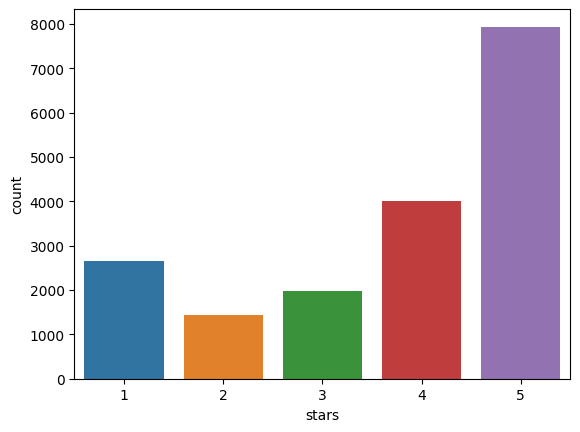

In [190]:
# Observe the distribution of the dataset
import seaborn as sns
sns.countplot(x='stars', data=reviews)

In [191]:
dataset_info = {"1":0, "2":0, "3":0, "4":0, "5":0}
for rating in reviews["stars"]:
    dataset_info[str(rating)] += 1
print(f"Dataset distribution: {dataset_info}")

for rating in dataset_info:
    dataset_info[rating] /= len(reviews["stars"])
    dataset_info[rating] = round(dataset_info[rating], 2)
print(f"Dataset distribution(%): {dataset_info}")

# Dataset is imbalance: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

Dataset distribution: {'1': 2659, '2': 1426, '3': 1969, '4': 4008, '5': 7938}
Dataset distribution(%): {'1': 0.15, '2': 0.08, '3': 0.11, '4': 0.22, '5': 0.44}


Text Preprocessing

In [277]:
lemmatizer = WordNetLemmatizer()
# nltk stopword is not suitable for this project so stopwords list is modified
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',  "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such','own', 'same', 's', 't', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'ma', 'shan']

In [207]:
def preprocess_text(text):
  # 1. remove special character (e.g. \n (new line character), \d)
  no_spec_char = re.sub(r"(\s?\\\w)", " ", text)

  # 2. remove number (e.g. 1, 145, 34... etc)
  no_num = re.sub(r"\d+", " ", no_spec_char)
  no_num = re.sub(r"was", " ", no_num)

  # 3. remove punctuation
  # string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
  no_punc = [char for char in no_num if char not in string.punctuation]
  no_punc = ''.join(no_punc)

  # 4. tokenization
  tokenize = nltk.word_tokenize(no_punc)

  # 5. Lower casing
  lower = [word.lower() for word in tokenize]

  # 6. perform lammatization/stemming
  lem_word = [lemmatizer.lemmatize(word) for word in lower]
 
  # 7. remove stopwords (useless words and data)
  clean_words = [word.lower() for word in lem_word if word.lower() not in stop_words]
  
  return clean_words

In [ ]:
# string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
new = preprocess_text(reviews["text"][5])
new

In [209]:
train_X = []
for review in list(reviews["text"]):
    train_X.append(preprocess_text(review))

In [210]:
train_X = np.array(train_X)
np.save("training_data.npy", train_X)

/tmp/ipykernel_294/1138643754.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.array(train_X)


Converting word to vector

In [280]:
train_X = np.load("training_data.npy", allow_pickle=True)

In [82]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [287]:
vec_reviews = []
percentage = 0
for i, review in enumerate(train_X):
    vec_review = []
    banchmark = int(len(review)*percentage)
    for j, word in enumerate(review):
        try:
            wordvec = glove[word]
            vec_review.append(wordvec)
        except:
            #print(f"[{word}] in review {i} cannot be converted to vector and thus removed")
            pass
    if (len(vec_review) >= banchmark):
        vec_reviews.append(vec_review)

In [288]:
print(f"number of data before word to vector: {len(train_X)}")
print(f"number of data after word to vector: {len(vec_reviews)}")
print(f"number of data removed (more than 30% of contecnt is not english): {len(train_X)-len(vec_reviews)}")

number of data before word to vector: 18000
number of data after word to vector: 18000
number of data removed (more than 30% of contecnt is not english): 0


In [ ]:
# Word embedding GloVe: https://www.youtube.com/watch?v=Fn_U2OG1uqI&ab_channel=NormalizedNerd
# https://www.youtube.com/watch?v=InCWrgrUJT8&ab_channel=Scarlett%27sLog